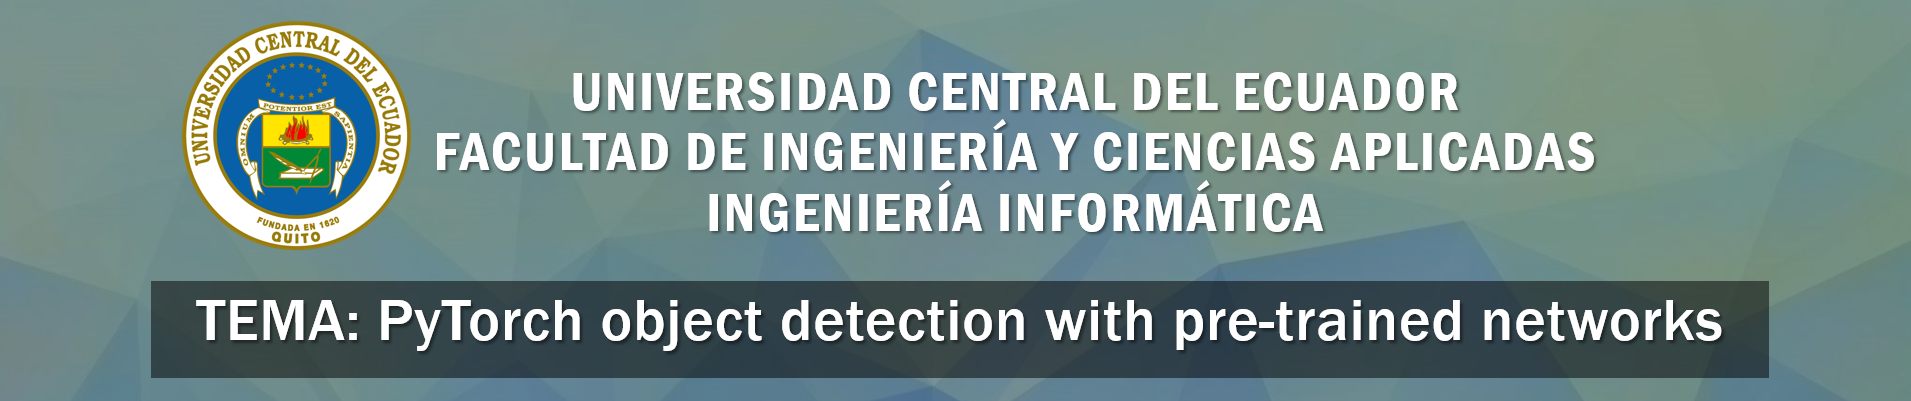

## **PyTorch object detection with pre-trained networks**
#####Código Fuente: https://www.pyimagesearch.com/2021/08/02/pytorch-object-detection-with-pre-trained-networks/

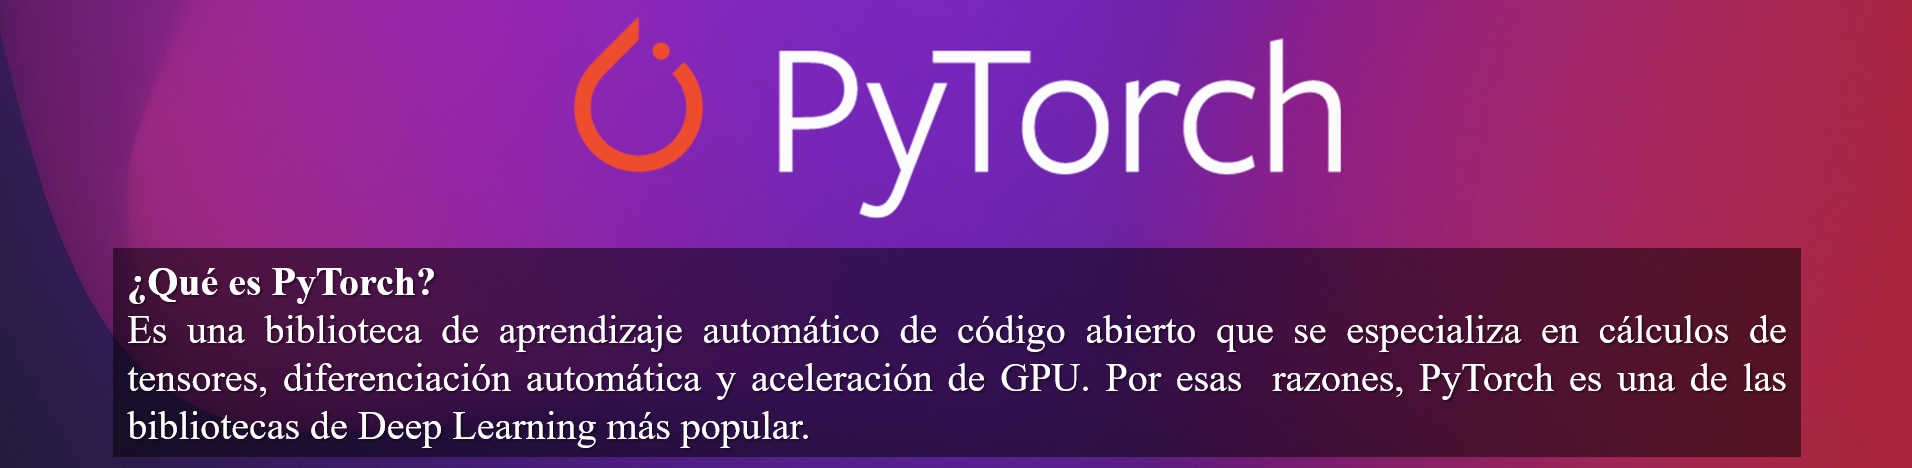

### **Usar la carpeta que contiene las imagenes y la clase COCO**




In [ ]:

from google.colab import drive
drive.mount('/content/drive')
#!cp "/content/drive/My Drive/pytorch-object-detection
%cd drive/MyDrive/pytorch-object-detection

#from google.colab import files 
#files.upload()  

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/pytorch-object-detection


### **Implementación del código**

#### **Importar los paquetes necesarios**

In [ ]:
#El paquete de torchvision consta de conjuntos de datos populares, arquitecturas 
#de modelos y transformaciones de imágenes comunes para la visión por 
#computadora.
from torchvision.models import detection
#El módulo "detection"contiene los detectores de objetos pre-entrenados de 
#PyTorch.
import matplotlib.pyplot as plt
#Matplotlib es una librería de Python especializada en la creación de gráficos 
#en dos dimensiones.
import numpy as np
#NumPy es una librería de Python especializada en el cálculo numérico y 
#el análisis de datos, especialmente para un gran volumen de datos.
#"np" arrays, Un array es una estructura de datos de un mismo tipo organizada 
#en forma de tabla o cuadrícula de distintas dimensiones.
import argparse
#argparse — Analizador sintáctico (Parser) para las opciones, argumentos y 
#sub-comandos de la línea de comandos
#El módulo argparse facilita la escritura de interfaces de línea de comandos 
#amigables. El programa define qué argumentos requiere, y argparse averiguará 
#cómo analizar los de sys.argv. El módulo argparse también genera automáticamente
#mensajes de ayuda y de uso y muestra errores cuando los usuarios dan parámetros 
#incorrectos al programa.
import pickle
#El módulo pickle implementa un algoritmo para convertir un objeto arbitrario 
#Python en una serie de bytes. Este proceso es también llamado serialización de 
#objetos. El flujo de bytes que representa al objeto puede ser transmitido o 
#almacenado, y luego reconstruido para crear un nuevo objeto con las mismas 
#características.
import torch
#Torch es una biblioteca de código abierto para aprendizaje automático, un marco 
#de computación científica, y un lenguaje de script basado en el lenguaje de 
#programación Lua.
import cv2
#OpenCv (Open Source Computer Vision)
#Actualmente es la biblioteca de visión por computadora más grande en términos 
#de funciones poseídas.
#Actualmente, OpenCV contiene implementaciones de más de 2500 algoritmos. Además 
#está disponible de forma gratuita para fines comerciales y académicos.

####**Función para mostrar imágenes en Jupyter Notebooks y Google Colab**

In [ ]:
def plt_imshow(title, image):
#Convierta el marco de imagen BGR al espacio de color RGB y muéstrelo
#Generalmente, las imágenes leídas por cv2 son imágenes en el espacio de color BGR; 
#los fotogramas de video obtenidos por cv2 son imágenes en el espacio de color RGB; 
#las imágenes leídas por PIL (Python Image Library) son imágenes en color RGB espacio.
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

#### **Implementando el script de detección de objetos en PyTorch**

In [ ]:
# construir el analizador de argumentos y analizar los argumentos
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--image", type=str, required=True,
# 	help="path to the input image")
# ap.add_argument("-m", "--model", type=str, default="frcnn-resnet",
# 	choices=["frcnn-resnet", "frcnn-mobilenet", "retinanet"],
# 	help="name of the object detection model")
# ap.add_argument("-l", "--labels", type=str, default="coco_classes.pickle",
# 	help="path to file containing list of categories in COCO dataset")
# ap.add_argument("-c", "--confidence", type=float, default=0.5,
# 	help="minimum probability to filter weak detections")
# args = vars(ap.parse_args())
args = {
#Galeria de Imagenes
     "image": "images/example_01.jpg",
#     "image": "images/example_02.jpg",
#     "image": "images/example_03.jpg",
#     "image": "images/example_04.jpg",
#     "image": "images/example_05.jpg",
#     "image": "images/example_06.jpg",
#     "image": "images/example_07.jpg",
#     "image": "images/example_08.jpg",
#     "image": "images/example_09.jpg",
#     "image": "images/example_010.jpg",
#     "image": "images/example_013.jpg",
#--------------------------------------------------------------------
###SEÑALES DE TRANSITO FASE II
#--------------------------------------------------------------------
#    "image": "transito/example_029.jpg",
#    "image": "transito/example_032.jpg",
#    "image": "transito/example_040.jpg",
#    "image": "transito/example_041.jpg",
#    "image": "transito/example_042.jpg",
#    "image": "transito/example_043.jpg",
#    "image": "transito/example_044.jpg",
#    "image": "transito/example_045.jpg",

#-----Usar el modelo requerido-------------
#---Podemos elegir entre tres modelos, que incluye Pytorch-------
     "model": "frcnn-resnet",
#     "model": "frcnn-mobilenet",
#     "model": "retinanet",
#-----------------------------------------------------------------
    "labels": "coco_classes.pickle",
#--Cargamos la clase coco_classes.pickle
    "confidence": 0.5
#Confiabilidad, precision. Mientras mas pequeño el valor el modelo detecta mas 
#objetos pero pierde precision al detectar objetos.
}

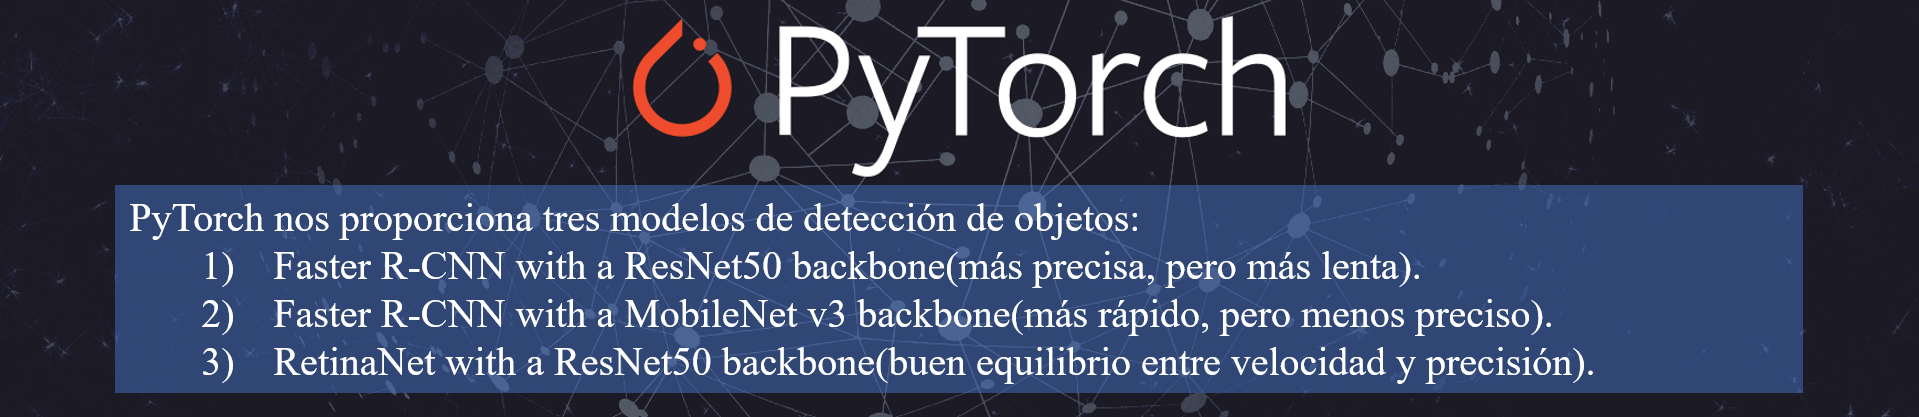

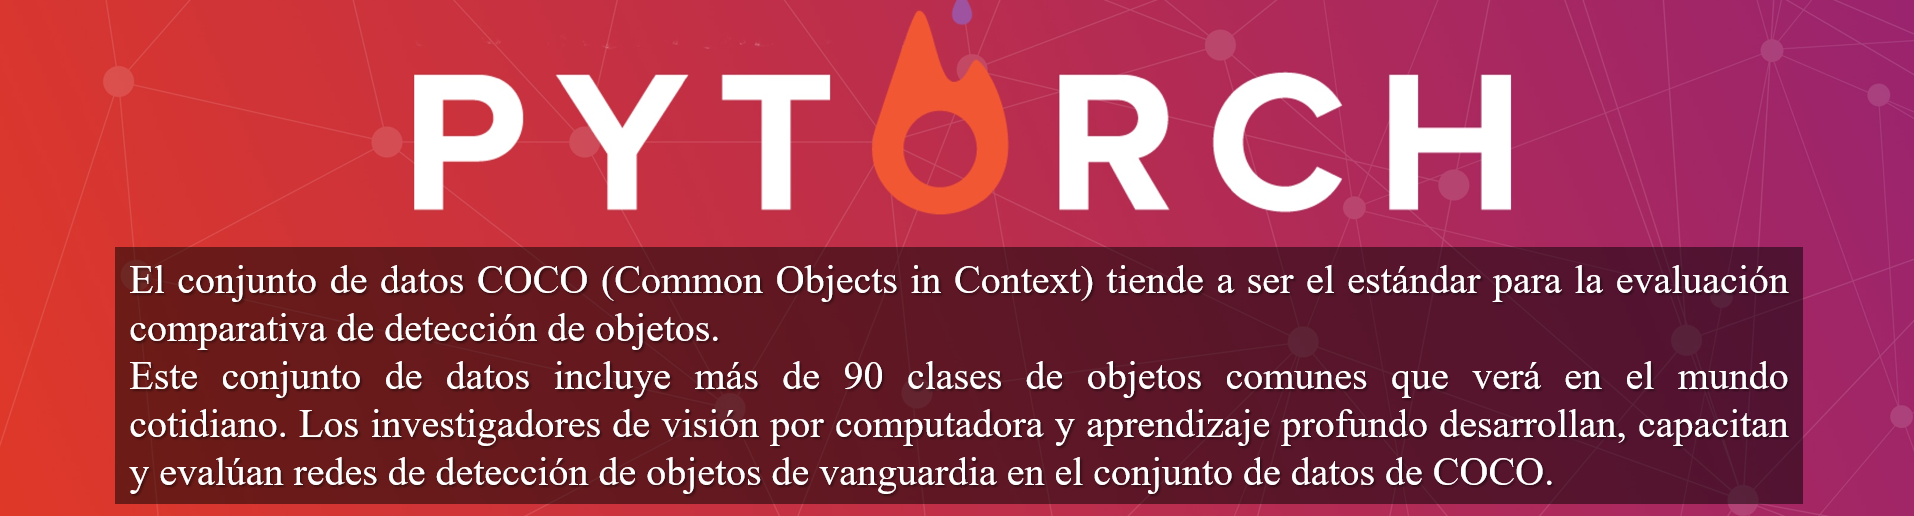

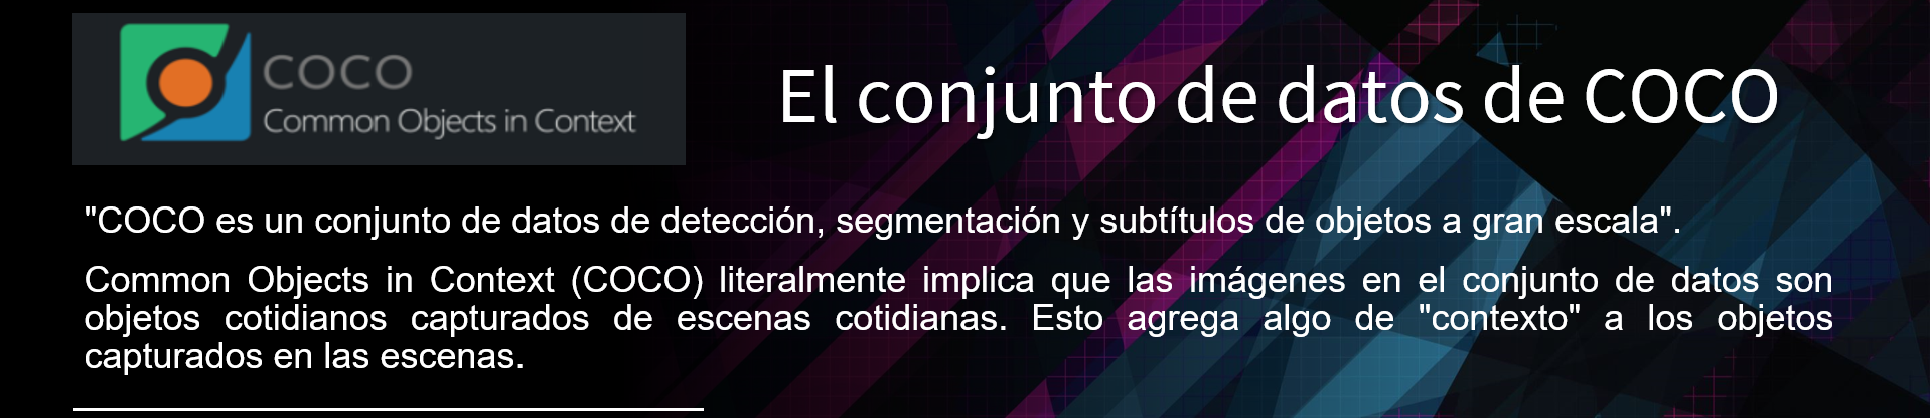

In [ ]:
# Configura el dispositivo que usaremos para ejecutar el modelo
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#--establece el dispositivo que usaremos para la inferencia (ya sea CPU o GPU).
# cargue la lista de categorías en el conjunto de datos COCO y luego genere un
# conjunto de colores de cuadro delimitador para cada clase
CLASSES = pickle.loads(open(args["labels"], "rb").read())
#cargamos nuestras etiquetas de clase desde el disco
COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))
#--Usaremos estos colores al dibujar cuadros delimitadores y etiquetas predichos 
#--en nuestra imagen de salida.

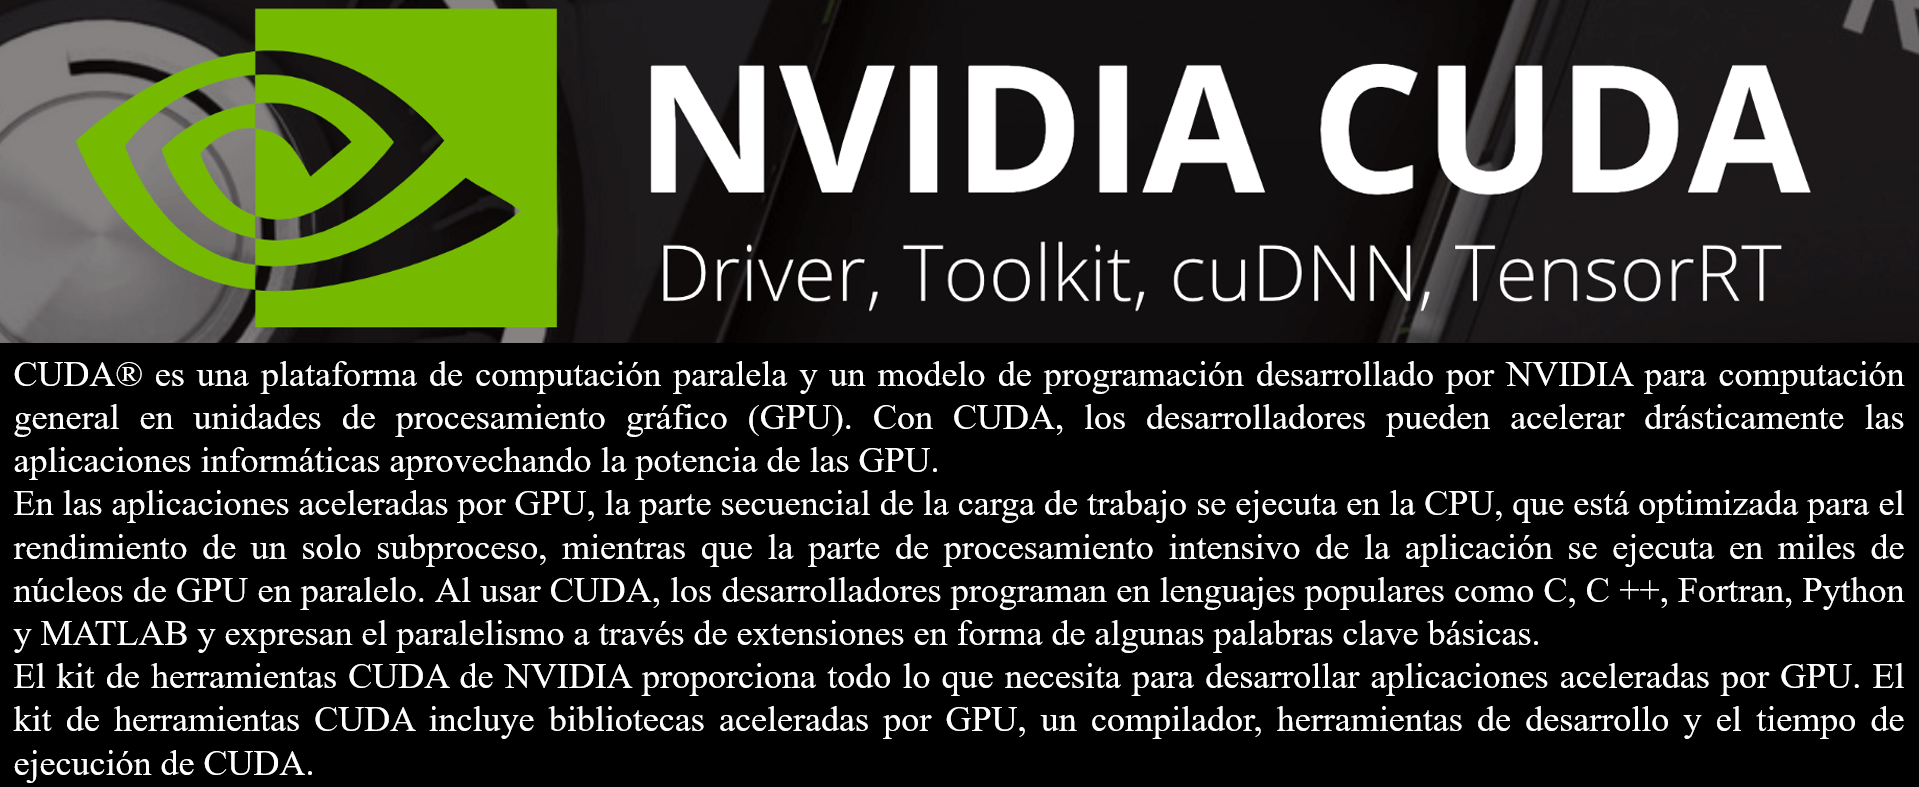

In [ ]:
#--Definimos un MODELOS diccionario para mapear el nombre de un detector de objetos 
#--dado a su función PyTorch correspondiente
# inicializar un diccionario que contenga el nombre del modelo y su correspondiente 
# llamada a la función de torchvision
MODELS = {
	"frcnn-resnet": detection.fasterrcnn_resnet50_fpn,
	"frcnn-mobilenet": detection.fasterrcnn_mobilenet_v3_large_320_fpn,
	"retinanet": detection.retinanet_resnet50_fpn
}

# cargue el modelo y configúrelo en modo de evaluación
model = MODELS[args["model"]](pretrained=True, progress=True,
	num_classes=len(CLASSES), pretrained_backbone=True).to(DEVICE)
#Pasamos una serie de parámetros clave, que incluyen:
#pretrained: Le dice a PyTorch que cargue la arquitectura del modelo con pesos 
#previamente entrenados en el conjunto de datos COCO
#progress=True: Muestra la barra de progreso de descarga si el modelo aún no 
#se ha descargado y almacenado en caché
#num_classes: Número total de clases únicas
#pretrained_backbone: También proporciona la red troncal al detector de objetos
model.eval()
#colocamos el modelo en modo de evaluación 
print("")


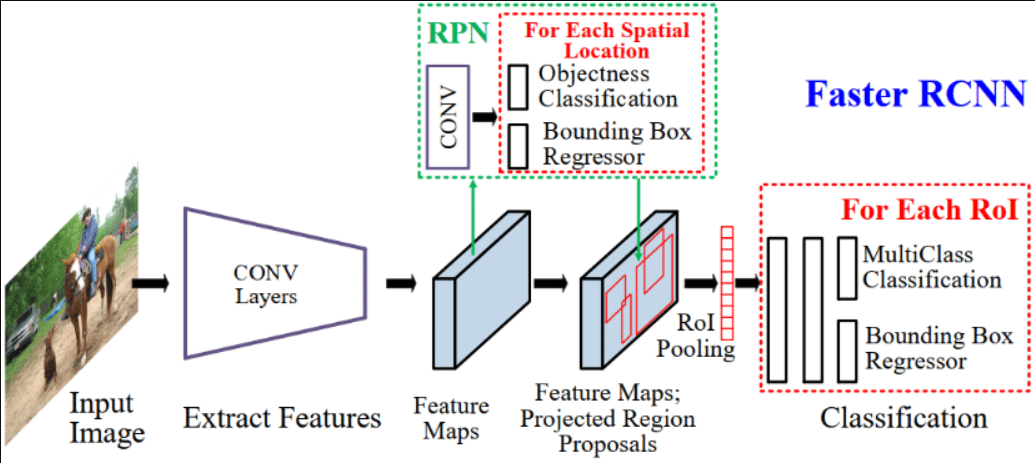

In [ ]:
# carga la imagen desde el disco
image = cv2.imread(args["image"])
orig = image.copy()

# convierta la imagen de BGR a orden de canal RGB y cambie el
# imagen de los últimos canales al primer pedido de los canales
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image.transpose((2, 0, 1))

# agregue la dimensión del lote, escale las intensidades de píxeles sin procesar al
# rango [0, 1] y convierte la imagen en un tensor de punto flotante
image = np.expand_dims(image, axis=0)
image = image / 255.0
image = torch.FloatTensor(image)

# enviar la entrada al dispositivo y pasarla a través de la red a
# obtener las detecciones y predicciones
image = image.to(DEVICE)
detections = model(image)[0]
###############################################
#Preprocesamos nuestra imagen mediante:
#1.Conversión de pedidos de canales de color de BGR a RGB (ya que los modelos de 
#PyTorch se entrenaron en imágenes ordenadas en RGB)
#2.Cambiar el orden de los canales de color de "los últimos canales" (OpenCV y 
#Keras / TensorFlow predeterminados) a "canales primero" (PyTorch predeterminado)
#3.Agregar una dimensión de lote
#4.Escala de intensidades de píxeles desde el rango [0, 255] a [0, 1]
#5Conversión de la imagen de una matriz NumPy a un tensor con un tipo de datos 
#de punto flotante

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


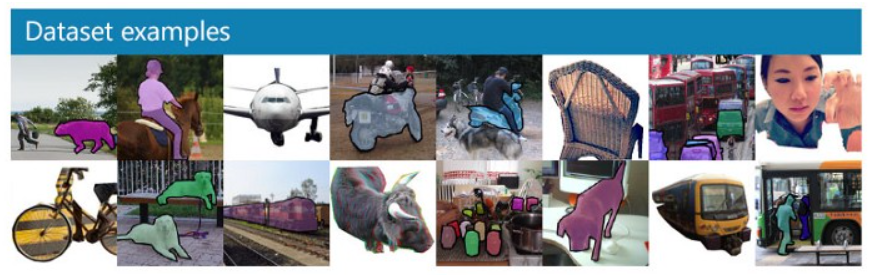

[INFO] clock: 98.12%
[INFO] tv: 76.66%
[INFO] bowl: 51.05%


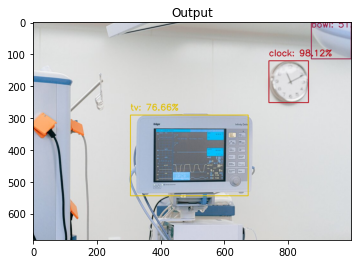

In [ ]:
# recorrer las detecciones
for i in range(0, len(detections["boxes"])):
	# extraer la confianza (es decir, la probabilidad) asociada con la
	# predicción
	confidence = detections["scores"][i]

	# filtrar las detecciones débiles asegurándose de que la confianza sea
	# mayor que la confianza mínima
	if confidence > args["confidence"]:
		# extraer el índice de la etiqueta de clase de las detecciones,
		# luego calcule las coordenadas (x, y) del cuadro delimitador
		# para el objeto
		idx = int(detections["labels"][i])
		box = detections["boxes"][i].detach().cpu().numpy()
		(startX, startY, endX, endY) = box.astype("int")

		# mostrar la predicción en nuestra terminal
		label = "{}: {:.2f}%".format(CLASSES[idx], confidence * 100)
		print("[INFO] {}".format(label))

		# dibuja el cuadro delimitador y la etiqueta en la imagen
		cv2.rectangle(orig, (startX, startY), (endX, endY),
			COLORS[idx], 2)
		y = startY - 15 if startY - 15 > 15 else startY + 15
		cv2.putText(orig, label, (startX, y),
			cv2.FONT_HERSHEY_SIMPLEX, 0.9, COLORS[idx], 2)
  
# mostrar la imagen de salida
plt_imshow("Output", orig)
